# Realtime Emotion Recognition with Tensorflow

In [80]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import random
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
img = cv2.imread("train/0/image0019669.jpg")
if img is not None:
    print(img.shape)
else:
    print("Failed to load the image.")

(96, 96, 3)


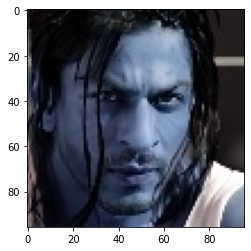

In [3]:
plt.imshow(img)

In [4]:
Datadirectory = "train/"
Classes = ["0", "1", "2", "3", "4", "5", "6", "7"] #"anger", "contempt", "disgust", "fear", "happy", "neutral", "sad", "surprise"

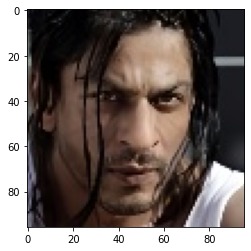

In [5]:
for category in Classes:
    path = os.path.join(Datadirectory, category)
    for im in os.listdir(path):
        img = cv2.imread(os.path.join(path, im))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
        break
    break #breaks in order to not display thousands of images

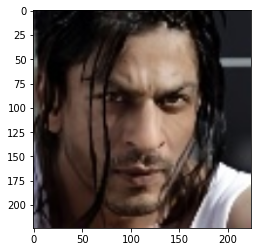

In [7]:
#for ImageNet we need size 224 x 224
new_img = cv2.resize(img, (224, 224))
plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
plt.show()

### Converting Images to Array

In [79]:
# create and return a data generator
def data_generator(batch_size):
    while True:
        training = []  # a new training list for each batch

        for category in Classes:
            path = os.path.join(Datadirectory, category)
            class_num = Classes.index(category)

            # randomly shuffle image filenames
            images = os.listdir(path)
            random.shuffle(images)

            for im in images:
                try:
                    img = cv2.imread(os.path.join(path, im))
                    new_img = cv2.resize(img, (224, 224))
                    training.append([new_img, class_num])
                except Exception as e:
                    pass

                # yield the batch when it reaches the specified size
                if len(training) == batch_size:
                    random.shuffle(training)
                    X = []  # features
                    Y = []  # labels

                    for feature, label in training:
                        X.append(feature)
                        Y.append(label)

                    X = np.array(X).reshape(-1, 224, 224, 3)  # convert to 4D array
                    X = X / 255.0  # normalize pixels

                    yield X, np.array(Y)
                    training = []  # reset the training list for the next batch

### Deep Learning Model

In [75]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [60]:
# Create and compile your model (MobileNetV2)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

In [59]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_12[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

### Transfer Learning

In [45]:
# freeze the MobileNetV2 layers
for layer in base_model.layers:
    layer.trainable = False
    
model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512),
    BatchNormalization(),
    tf.keras.layers.ReLU(),
    Dense(len(Classes), activation='softmax')
])


opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.95, beta_2=0.95)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# the data generator with a specified batch size
batch_size = 64
data_gen = data_generator(batch_size)

# the number of steps per epoch
num_samples = sum(len(os.listdir(os.path.join(Datadirectory, category))) for category in Classes)
steps_per_epoch = num_samples // batch_size

# training a model using the data generator
model.fit(data_gen, epochs=100, steps_per_epoch=steps_per_epoch)

Epoch 1/100
216/216 [==============================] - 145s 662ms/step - loss: 3.5154 - accuracy: 0.0516
Epoch 2/100
216/216 [==============================] - 125s 577ms/step - loss: 3.0511 - accuracy: 0.0122
Epoch 3/100
216/216 [==============================] - 124s 576ms/step - loss: 3.0512 - accuracy: 0.0050
Epoch 4/100
216/216 [==============================] - 125s 577ms/step - loss: 3.0055 - accuracy: 0.0072
Epoch 5/100
216/216 [==============================] - 124s 573ms/step - loss: 2.9482 - accuracy: 0.0072
Epoch 6/100
216/216 [==============================] - 124s 573ms/step - loss: 2.8964 - accuracy: 0.0098
Epoch 7/100
216/216 [==============================] - 124s 572ms/step - loss: 2.8467 - accuracy: 0.0121
Epoch 8/100
216/216 [==============================] - 124s 572ms/step - loss: 2.8010 - accuracy: 0.0136
Epoch 9/100
216/216 [==============================] - 124s 573ms/step - loss: 2.7589 - accuracy: 0.0146
Epoch 10/100
216/216 [==============================] -

In [46]:
model.save('the_best_model.keras')

model = tf.keras.models.load_model('the_best_model.keras')

model.evaluate ##we won't use the test dataset, because we're doing the live demo

<bound method Model.evaluate of <keras.src.engine.sequential.Sequential object at 0x000001FB6430B3A0>>

### Test

In [61]:
frame = cv2.imread("fear_woman.jpg")
frame.shape

(360, 540, 3)

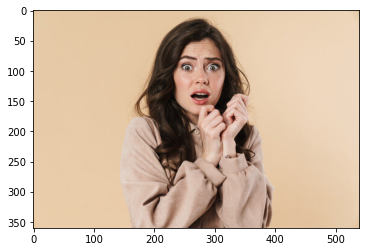

In [62]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [63]:
face = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [64]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

faces = face.detectMultiScale(gray, 1.1, 4)
for x, y, w, h in faces:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = frame[y:y+h, x:x+w]
    cv2.rectangle(frame, (x,y), (x+w, y+h), (255, 0, 0), 2)
    faces2 = face.detectMultiScale(roi_gray)
    if len(faces2) == 0:
        print("Face is not found")
    else:
        for (ex, ey, ew, eh) in faces2:
            face_roi = roi_color[ey:ey+eh, ex:ex+ew]

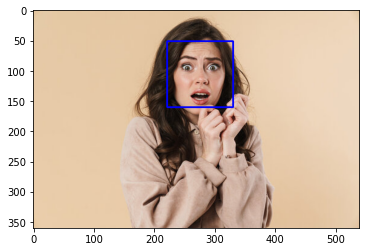

In [65]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

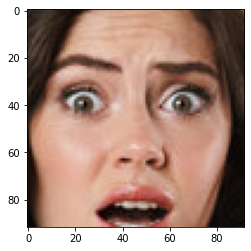

In [66]:
plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))

In [67]:
last_image = cv2.resize(face_roi, (224,224))
last_image = np.expand_dims(last_image, axis = 0) 
last_image = last_image/255

In [68]:
prediction = model.predict(last_image)

1/1 [==============================] - 0s 155ms/step


In [83]:
np.argmax(prediction)

5

In [84]:
prediction

array([[0.04948664, 0.0499235 , 0.00168978, 0.01879276, 0.2585487 ,
        0.37166733, 0.00702213, 0.24286921]], dtype=float32)

### Realtime Video Recognition

In [82]:
path = 'haarcascade_frontalface_default.xml'
font_scale = 1.5
font = cv2.FONT_HERSHEY_PLAIN
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

#white rectcangle background
rectangle_bgr = (255, 255, 255)

#black image
img = np.zeros((500,500))

#text in a box
text = "Some text"

#width and height of the box
(text_width, text_height) = cv2.getTextSize(text, font, fontScale=font_scale, thickness = 1)[0]

#text start position
text_x = 10
text_y = img.shape[0] - 25

#coords of the box with a small padding
coords = ((text_x, text_y), (text_x + text_width + 2, text_y - text_height -2))
cv2.rectangle(img, coords[0], coords[1], rectangle_bgr, cv2.FILLED)
cv2.putText(img, text, (text_x, text_y), font, fontScale = font_scale, color=(0,0,0), thickness=1)


cap = cv2.VideoCapture(1)
#webcam check
if not cap.isOpened():
    cap = cv2.VideoCapture(0)
    if  not cap.isOpened():
        raise IOError("Cannot open camera")
        
while True:
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray, 1.1, 4)

    for x, y, w, h in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

        # Preprocess the real-time face
        face_roi = cv2.resize(roi_color, (224, 224))
        face_roi = np.expand_dims(face_roi, axis=0)
        face_roi = face_roi / 255.0

        # Make real-time predictions
        Predictions = model.predict(face_roi)
    
    
    if (np.argmax(Predictions)==0):
        status = "Angry"
        
        x1,y1,w1,h1 = 0,0,175,75
        #Draw black rectangle
        cv2.rectangle(frame, (x1,x1), (x1 + w1, y1 + h1), (0,0,0), -1)
        #text
        cv2.putText(frame,status, (x1 + int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
        cv2.putText(frame, status, (100,150), font, 3, (0,0,255), 2, cv2.LINE_4)
        
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255))
        
    elif (np.argmax(Predictions)==1):
        status = "Contempt"
        
        x1,y1,w1,h1 = 0,0,175,75
        #Draw black rectangle
        cv2.rectangle(frame, (x1,x1), (x1 + w1, y1 + h1), (0,0,0), -1)
        #text
        cv2.putText(frame,status, (x1 + int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
        cv2.putText(frame, status, (100,150), font, 3, (0,0,255), 2, cv2.LINE_4)
        
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255))
        
    elif (np.argmax(Predictions)==2):
        status = "Disgust"
        
        x1,y1,w1,h1 = 0,0,175,75
        #Draw black rectangle
        cv2.rectangle(frame, (x1,x1), (x1 + w1, y1 + h1), (0,0,0), -1)
        #text
        cv2.putText(frame,status, (x1 + int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
        cv2.putText(frame, status, (100,150), font, 3, (0,0,255), 2, cv2.LINE_4)
        
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255))
        
        
    elif (np.argmax(Predictions)==3):
        status = "Fear"
        
        x1,y1,w1,h1 = 0,0,175,75
        #Draw black rectangle
        cv2.rectangle(frame, (x1,x1), (x1 + w1, y1 + h1), (0,0,0), -1)
        #text
        cv2.putText(frame,status, (x1 + int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
        cv2.putText(frame, status, (100,150), font, 3, (0,0,255), 2, cv2.LINE_4)
        
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255))
        
    elif (np.argmax(Predictions)==4):
        status = "Happy"
        
        x1,y1,w1,h1 = 0,0,175,75
        #Draw black rectangle
        cv2.rectangle(frame, (x1,x1), (x1 + w1, y1 + h1), (0,0,0), -1)
        #text
        cv2.putText(frame,status, (x1 + int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
        cv2.putText(frame, status, (100,150), font, 3, (0,0,255), 2, cv2.LINE_4)
        
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255))
        
    elif (np.argmax(Predictions)==5):
        status = "Neutral"
        
        x1,y1,w1,h1 = 0,0,175,75
        #Draw black rectangle
        cv2.rectangle(frame, (x1,x1), (x1 + w1, y1 + h1), (0,0,0), -1)
        #text
        cv2.putText(frame,status, (x1 + int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
        cv2.putText(frame, status, (100,150), font, 3, (0,0,255), 2, cv2.LINE_4)
        
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255))
        
    elif (np.argmax(Predictions)==6):
        status = "Sad"
        
        x1,y1,w1,h1 = 0,0,175,75
        #Draw black rectangle
        cv2.rectangle(frame, (x1,x1), (x1 + w1, y1 + h1), (0,0,0), -1)
        #text
        cv2.putText(frame,status, (x1 + int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
        cv2.putText(frame, status, (100,150), font, 3, (0,0,255), 2, cv2.LINE_4)
        
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255))
        
        
    elif (np.argmax(Predictions)==7):
        status = "Surprise"
        
        x1,y1,w1,h1 = 0,0,175,75
        #Draw black rectangle
        cv2.rectangle(frame, (x1,x1), (x1 + w1, y1 + h1), (0,0,0), -1)
        #text
        cv2.putText(frame,status, (x1 + int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
        cv2.putText(frame, status, (100,150), font, 3, (0,0,255), 2, cv2.LINE_4)
        
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255))
        
    cv2.imshow("Face Emotion Recognition", frame)
    
    if cv2.waitKey(2) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()
        

1/1 [==============================] - 0s 275ms/step


<div style="display: flex; justify-content: space-between;">
  <img src="demo pictures/happy.png" width="25%" />
  <img src="demo pictures/fear.png" width="25%" />
  <img src="demo pictures/surprise.png" width="25%" />
  <img src="demo pictures/neutral.png" width="25%" />
    
</div>